# Shiller Exercise
 
- Download the attached spreadsheet (chapt26.xlsx).
- Use Python 3x or Matlab and use the data (up to 1999) in this spreadsheet to replicate the Figure 6 (bottom panel) from the above paper. What are the regression statistics for these plots?
- Re-plot the above figures using all the available data in the spreadsheet (i.e. up to 2013). What the regression statistics for these plots?
- What are your key conclusions from these results?
- Design a two-asset (cash and S&P 500) investment strategy using your conclusions from above. Run a backtest on the strategy and send over the statistics that you think are most relevant to assess the strategy, along with your thoughts on the results.

In [732]:
import pandas as pd
import math
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.linear_model as lin
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import statsmodels.formula.api as smf


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [784]:
data = pd.read_excel('/Users/edwardhuang/Documents/chapt26.xlsx', sheet_name = 'Data_edit')

In [734]:
# Turn the index, which is the year, into its own column and re-index
data.reset_index(inplace = True)

data['year'] = data['index']
data.drop(columns = 'index', inplace = True)

In [735]:
data.shape

(146, 20)

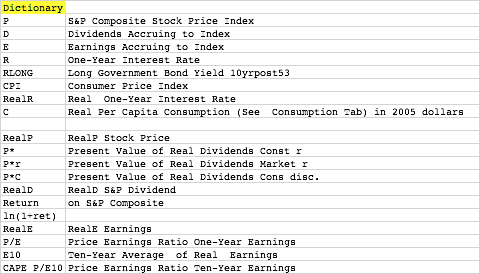

Notes:
- 146 years, 1871 - 2016
- 19 variables

## Task: Replicate Bottom Panel of Figure 6

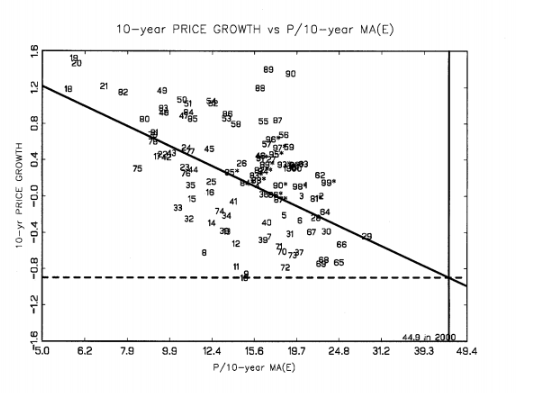

In [736]:
# Fig 6: 10 year Price Growth vs. P/10y MA(E)
# Paper here: http://www.nber.org/papers/w8221

In [737]:
# Subset Dataset to only years up to 1999 to create Shiller's old dataset at the time of research
dfa = data[data['year'] <= 1999]

In [738]:
# Create last CPI variable to reset the Real values based on 1999 last year.
last_cpi = dfa[dfa['year'] == 1999].iloc[0]['CPI']


In [739]:
# Recreate the Real Columns for Price and Earnings
dfa['RealP'] = dfa['P'] * last_cpi / dfa['CPI']
dfa['RealE'] = dfa['E'] * last_cpi / dfa['CPI']

In [740]:
# Get the Moving Average of Earnings, 10 years
dfa['E10'] = pd.rolling_mean(dfa, 10)['RealE']

# Get the CAPE, Real Price / E10 over last 10 years. Shift method lags the E10 by 10 years so I don't include the current year's earnings.
dfa['CAPE P/E10'] = dfa['RealP'] / dfa['E10'].shift(1)

In [741]:
# Get the change in natural log Price over next 10 years, on a rolling basis
dfa['P_Growth_10'] \
    = dfa['RealP'].shift(-10).apply(lambda x: math.log(x, math.e)) \
    - dfa['RealP'].apply(lambda x: math.log(x, math.e))

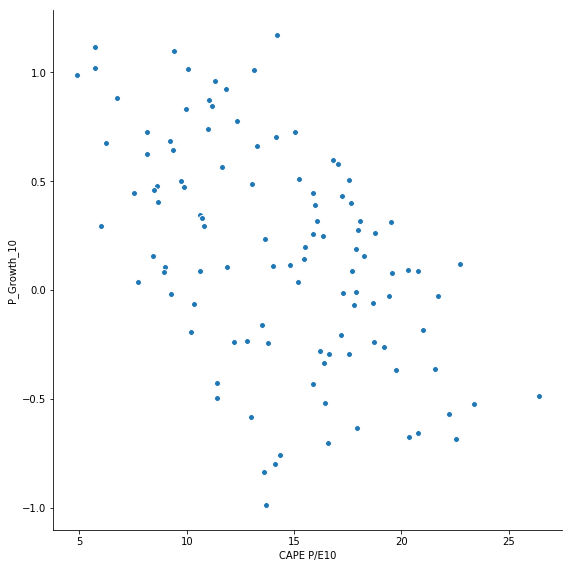

In [742]:
# Plot the scatterplot to check data before running regression
sns.pairplot(dfa, x_vars='CAPE P/E10', y_vars='P_Growth_10', size = 8, )

In [743]:
# Transform CAPE into natural log scale
dfa['log_CAPE'] = np.log(dfa['CAPE P/E10'])

In [744]:
# There are null values because of the Moving Averages (first 10 lines don't have a MA) and last 10 lines don't have 10y Price Growth
# Drop those null values for the regression
dfa = dfa[np.isfinite(dfa['log_CAPE'])]
dfa = dfa[np.isfinite(dfa['P_Growth_10'])]

In [745]:
X = dfa['log_CAPE']
y = dfa['P_Growth_10']

In [746]:
# Must reshape the matrix into 1 row each for regression
X = X.reshape(-1,1)
y = y.reshape(-1,1)

In [747]:
# Instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

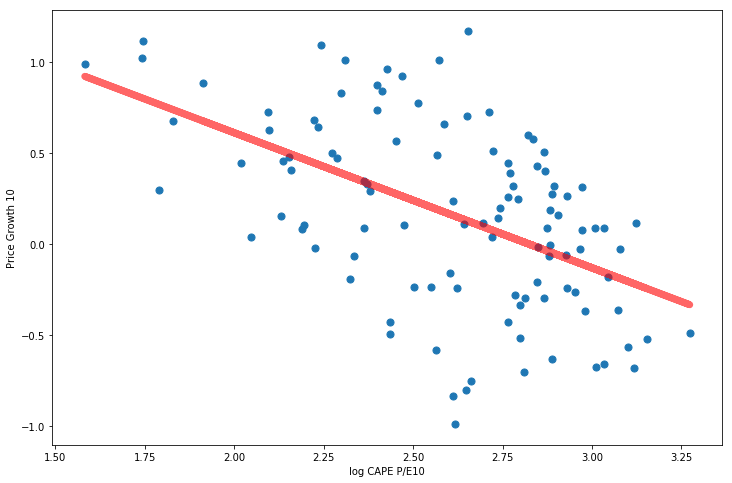

In [748]:
#Make predictions by passing X into model
preds = linreg.predict(X)

#Set plot size to (12,8)
plt.figure(figsize=(12, 8))
#Make scatter of X and y
plt.scatter(X,y, s = 50)
#Make line plot of X and preds
plt.plot(X, preds, "r", linewidth= 7, alpha = .6)
plt.xlabel("log CAPE P/E10")
plt.ylabel("Price Growth 10");

In [749]:
# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

[2.09782278]
[[-0.7428528]]


In [750]:
print("Mean squared error: %.2f"
      % mean_squared_error(y, preds))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, preds))

Mean squared error: 0.19
Variance score: 0.27


Formal Regression Equation: 
y = 2.1 - 0.74x

The explained variance is 27%

## Task: Recreate Model using all the available data in the spreadsheet (i.e. up to 2013).

In [751]:
# Create function with all the commands from above with variable inputs to make repetition easier

def data_trans(dfa, last_cpi_year):

    last_cpi = dfa[dfa['year'] == last_cpi_year].iloc[0]['CPI']
    
    # Recreate the Real Columns for Price and Earnings
    dfa['RealP'] = dfa['P'] * last_cpi / dfa['CPI']
    dfa['RealE'] = dfa['E'] * last_cpi / dfa['CPI']
    # Get the Moving Average of Earnings, 10 years
    dfa['E10'] = pd.rolling_mean(dfa, 10)['RealE']

    # Get the CAPE, Real Price / E10 over last 10 years. Shift method lags the E10 by 10 years so I don't include the current year's earnings.
    dfa['CAPE P/E10'] = dfa['RealP'] / dfa['E10'].shift(1)
    # Get the change in natural log Price over next 10 years, on a rolling basis
    dfa['P_Growth_10'] \
        = dfa['RealP'].shift(-10).apply(lambda x: math.log(x, math.e)) \
        - dfa['RealP'].apply(lambda x: math.log(x, math.e))

    # Transform CAPE into natural log scale
    dfa['log_CAPE'] = np.log(dfa['CAPE P/E10'])
    # There are null values because of the Moving Averages (first 10 lines don't have a MA) and last 10 lines don't have 10y Price Growth
    # Drop those null values for the regression
    dfa = dfa[np.isfinite(dfa['log_CAPE'])]
    dfa = dfa[np.isfinite(dfa['P_Growth_10'])]
    
    return dfa

In [752]:
def lin_reg(dfa, X_col):
    #X = dfa['log_CAPE']
    X = dfa[X_col]
    y = dfa['P_Growth_10']
    # Reshape only if there is only one column

    if len(X_col) == 1:
        X = np.array(X)
        
    y = y.reshape(-1,1)
    # Instantiate and fit
    linreg = LinearRegression()
    linreg.fit(X, y)
    #Make predictions by passing X into model
    preds = linreg.predict(X)
    
    # print the coefficients
    print('y = ',linreg.coef_,'x + ',linreg.intercept_)
    print("Mean squared error: %.2f"
          % mean_squared_error(y, preds))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y, preds))
    
    return preds

In [753]:
# Change dataset up to 2013
dfa = data[data['year'] <= 2013]

In [754]:
preds1 = lin_reg(data_trans(dfa, 2013), ['log_CAPE'])

y =  [[-0.57675713]] x +  [1.72319056]
Mean squared error: 0.21
Variance score: 0.20


Check p values to make sure variables are significant

In [755]:
import statsmodels.formula.api as smf

# create a fitted model
lm1 = smf.ols(formula='P_Growth_10 ~ log_CAPE', data=dfa).fit()
lm1.pvalues

Intercept    1.379098e-08
log_CAPE     2.129062e-07
dtype: float64

## What are your key conclusions from these results?

MSE increased and Explained Variance decreased for the model in the years between 1999 and 2013.

The drop from .27 to .20 in R^2 suggests that the CAPE ratio has had less ability to predict market Price movement over the last 15 or so years. The question that arises from this observation is whether this is a temporary departure or if we have encountered a regime shift.

Regime shift possible explanations are included in the critiques in the attached Word Doc.
- Structural Changes to Index
- Changes to Accounting Practices
- Payout Ratio Changes

## Model Improvement Ideas:
1. CAPE gets affected too much from terrible years, where Earnings completely crashes. Try removing 2008 and 2009 to - see what happens to R^2
2. Quantitative Easing and Super low interest rates post Recession are supporting CAPE at very elevated levels and keeping price growth decent. Factor in Real 10y Interest Rates.

### 1.

In [756]:
# Remove the 2008 and 2009 poor Earnings years to see if R^2 improves
dfa = data[(data['year'] <= 2013) & (data['year'] != 2008) & (data['year'] != 2009)]

preds2 = lin_reg(data_trans(dfa, 2013), ['log_CAPE'])

y =  [[-0.56911425]] x +  [1.70183033]
Mean squared error: 0.21
Variance score: 0.19


Simply removing first Recession years did not help the R^2 improve.

### 2.

In [757]:
dfa = data[data['year'] <= 2013]
dfa['Real_RLONG'] = dfa['RLONG'] * last_cpi / dfa['CPI']

preds3 = lin_reg(data_trans(dfa, 2013), ['log_CAPE','Real_RLONG'])

y =  [[-0.59498886 -0.00676589]] x +  [2.02447913]
Mean squared error: 0.18
Variance score: 0.30


In [758]:
# Check pvalues to make sure variables are significant
lm1 = smf.ols(formula='P_Growth_10 ~ log_CAPE + Real_RLONG', data=dfa).fit()
lm1.pvalues

Intercept     2.288402e-11
log_CAPE      1.653778e-08
Real_RLONG    4.469809e-05
dtype: float64

Taking into account 10y Real Interest rates *did* help R^2 improve. 

Using 10y Real interest rates as an indicator of Fed dovishness and Quantitative Easing over recent years helped the model explain more of the Price Growth Variance

## Investment Strategy Ideas:
1. Simple binary investing cash vs sp500 based on price growth predictor, reevaluate 1 year cycles
2. Weighted investing - take mean/std of y pred and invest proportionally. reevaluate 1 year cycles


### 1.

- When CAPE predicts Price Growth over next 10 years to be positive, allocate 100% to S&P 500. 
- When prediction is negative, allocate 100% to cash.

First, use model with only CAPE as predictor variable.

In [759]:
dfa = data[data['year'] <= 2013]
dfa = data_trans(dfa, 2013)


In [760]:
def category(y_pred):
    if y_pred > 0:
        return 1
    else:
        return 0

In [761]:
# Set Current Strategy to Strat1
dfa['y_pred1'] = preds1
y_pred = 'y_pred1'

Create Visual to show years when strategy is in Cash vs years when strategy is in S&P 500

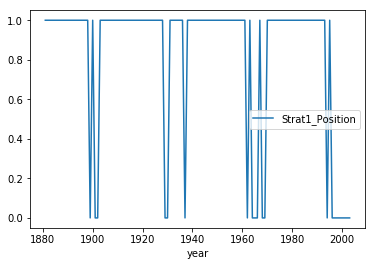

In [762]:
dfa['Strat1_Position'] = dfa[y_pred].apply(category)
dfa.plot(x = 'year', y = 'Strat1_Position')

In [763]:
def strat(dfa):
    pct_growth = dfa['Return']

    if dfa[y_pred] > 0:
        return 1 + pct_growth
    else:
        return 1

In [764]:
dfa['Strat1_Return'] = dfa.apply(strat, axis = 1)

In [765]:
dfa['Cum_Strat1_Return'] = dfa['Strat1_Return'].cumprod()
dfa['sp500_running_return'] = dfa['Return'].apply(lambda x: x+1).cumprod()

Overlay Strategy Performance vs S&P 500 Benchmark and highlight years when Strategy is holding cash

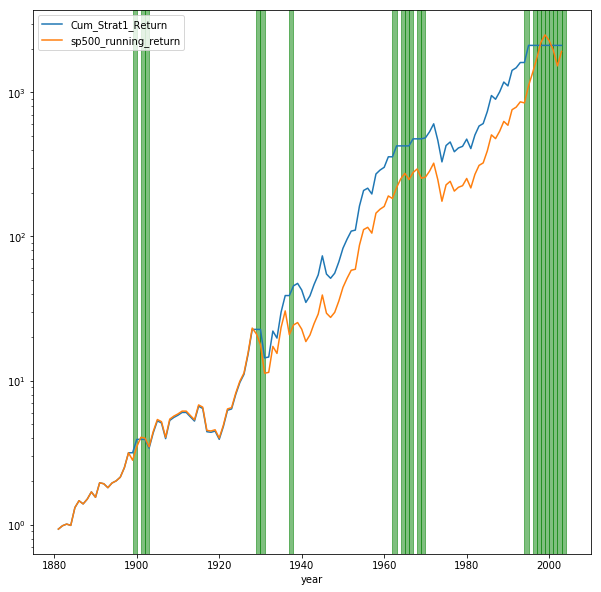

In [766]:
dfa.plot(x = 'year', y = ['Cum_Strat1_Return', 'sp500_running_return'], logy = True, figsize = (10,10))
for year in dfa[dfa['Strat1_Position'] == 0]['year']:
    plt.axvspan(year, year+1, color='green', alpha=0.5)
#https://stackoverflow.com/questions/8270981/in-a-matplotlib-plot-can-i-highlight-specific-x-value-ranges

Now, try the model with higher R^2 (both CAPE and Real 10y Interest Rates as predictor variables)

In [767]:
# Set Current Strategy to Strat1
dfa['y_pred2'] = preds3
y_pred = 'y_pred2'

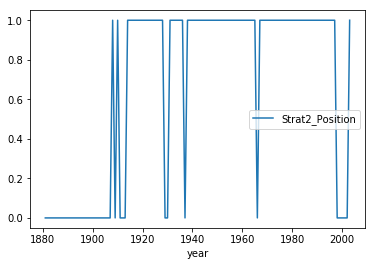

In [768]:
dfa['Strat2_Position'] = dfa[y_pred].apply(category)
dfa.plot(x = 'year', y = 'Strat2_Position')

In [769]:
dfa['Strat2_Return'] = dfa.apply(strat, axis = 1)
dfa['Cum_Strat2_Return'] = dfa['Strat2_Return'].cumprod()

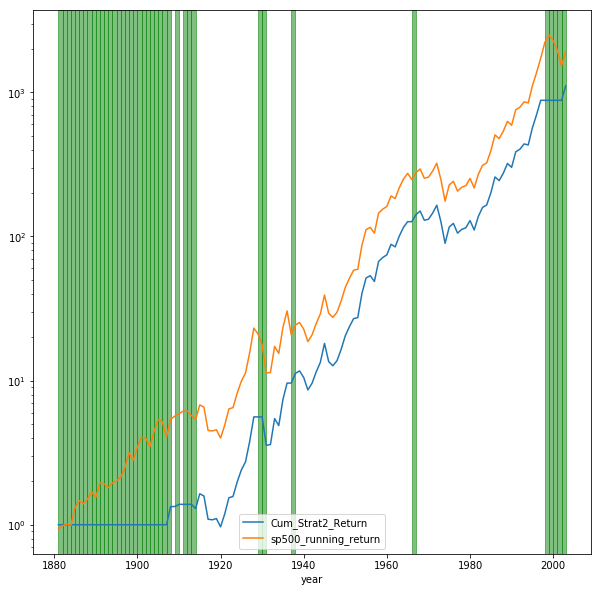

In [770]:
dfa.plot(x = 'year', y = ['Cum_Strat2_Return', 'sp500_running_return'], logy = True, figsize = (10,10))
for year in dfa[dfa['Strat2_Position'] == 0]['year']:
    plt.axvspan(year, year+1, color='green', alpha=0.5)
#https://stackoverflow.com/questions/8270981/in-a-matplotlib-plot-can-i-highlight-specific-x-value-ranges

Strange...Model has a better R^2 but Total Return is Worse. Maybe this indicates that using a brute 0/1 allocation strategy does not accommodate the nuances of y_pred magnitudes.

We should try a strategy that has a more flexible weighting system rather than binary.

### 2.

### Work in Progress - Need to develop a smart way of creating intervals and varying weights to invest in a cash/equity portfolio

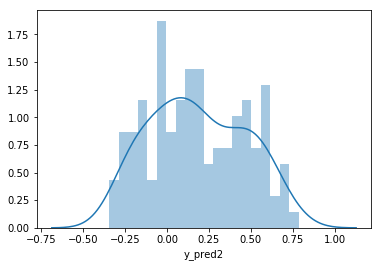

In [771]:
sns.distplot(dfa['y_pred2'], bins = 20)

In [772]:
print('Median: ',dfa['y_pred2'].median())
print('Mean: ',dfa['y_pred2'].mean())

Median:  0.15483047104249348
Mean:  0.18306007787863432


Histogram has a positive mean, right tail skew. Steep Slope on left side.

## Strategy Assessment Statistics

### Check Max Drawdowns

In [773]:
print('S&P 500 Benchmark Max Drawdown: ',dfa['Return'].min())
print('Strat1 Max Drawdown: ',(dfa['Strat1_Return']-1).min())
print('Strat2 Max Drawdown: ',(dfa['Strat2_Return']-1).min())

S&P 500 Benchmark Max Drawdown:  -0.36543056442931293
Strat1 Max Drawdown:  -0.365430564429313
Strat2 Max Drawdown:  -0.365430564429313


Note: None of these avoided the Max Drawdown

### Compare the number of years where each strategy had positive and negative Returns compared to benchmark S&P 500

In [774]:
foo = pd.DataFrame(dfa['Return'].apply(lambda x: 1 if x > 0 else 0 if x == 0 else -1).value_counts())

In [775]:
foo1 = pd.DataFrame((dfa['Strat1_Return']-1).apply(lambda x: 1 if x > 0 else 0 if x == 0 else -1).value_counts())
foo2 = pd.DataFrame((dfa['Strat2_Return']-1).apply(lambda x: 1 if x > 0 else 0 if x == 0 else -1).value_counts())

In [776]:
foo.join((foo1,foo2), how = 'outer')

,Return,Strat1_Return,Strat2_Return
-1,41.0,29,21
0,NaN,21,40
1,82.0,73,62


- Strategy1 reduced negative Returns by 12/41 (29%) and positive returns by 9/82 (10%)
- Strategy2 reduced negative Returns by 20/41 (49%) and positive returns by 20/82 (24%)

### Check Histogram for Volatility

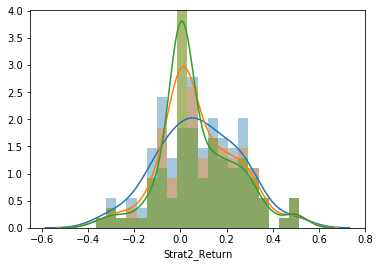

In [777]:
# compare all years vs strategy s&p invested years
sns.distplot(dfa['Return'], bins = 20)
sns.distplot(dfa['Strat1_Return'] -1, bins = 20)
sns.distplot(dfa['Strat2_Return'] -1, bins = 20)

Blue line is Strategy, looks like it is skinnier which means volatility is lower.

Mean and median look around the same. Lets see the actual numbers.

### Get STD and Mean of each strategy

In [778]:
print('Benchmark Mean is: ', dfa['Return'].mean())
print('Benchmark STD is: ', dfa['Return'].std())

Benchmark Mean is:  0.07880021464458054
Benchmark STD is:  0.1802464782375121


In [779]:
print('Strat1 Mean is: ', (dfa['Strat1_Return']-1).mean())
print('Strat1 STD is: ', (dfa['Strat1_Return']-1).std())

Strat1 Mean is:  0.07713590272805919
Strat1 STD is:  0.1667567242665127


In [780]:
print('Strat2 Mean is: ', (dfa['Strat2_Return']-1).mean())
print('Strat2 STD is: ', (dfa['Strat2_Return']-1).std())

Strat2 Mean is:  0.07056723969890341
Strat2 STD is:  0.16088701715697315


In [781]:
df = pd.DataFrame([[(dfa['Strat1_Return']-1).mean(), (dfa['Strat1_Return']-1).std(), "y"],
                   [(dfa['Strat2_Return']-1).mean(), (dfa['Strat2_Return']-1).std(), "r"],
                 [dfa['Return'].mean(), dfa['Return'].std(), "b"]],
                 columns = ['mean','std', 'color'])

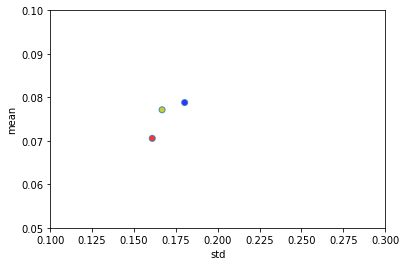

In [782]:
f, ax = plt.subplots()
ax.set(xlim=(.1, .3), ylim=(0.05, .1))
sns.regplot(x = 'std', y= 'mean', data = df, fit_reg=False, scatter_kws={'facecolors':df['color']})

#https://python-graph-gallery.com/45-control-color-of-each-marker-seaborn/



- Blue Dot is S&P 500 benchmark
- Yellow Dot is Strat1
- Red Dot is Strat2

Note: need to add my #2 investment strategy of weighted portfolio


# Appendix and Work in Progress Below - Ignore

## Run a backtest on the strategy and send over the statistics that you think are most relevant to assess the strategy, along with your thoughts on the results.

Instead of using the 25% and 75% bounds as fixed numbers for all time, why don't you do a MA for 20 years (arbitrarily picked) to try to keep CAPE updated and avoid the regime differences within the 100+ years time frame.

In [32]:
# MA timeframe
window = 20

In [33]:
strat['CAPE_lower_bound'] = strat.rolling(window=window,center=False).quantile(0.25)['CAPE P/E10']
strat['CAPE_upper_bound'] = strat.rolling(window=window,center=False).quantile(0.75)['CAPE P/E10']

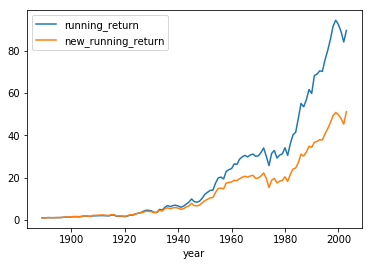

In [34]:
strat['new_return'] = strat.apply(weighted_sp500, axis = 1)
strat['new_category'] = strat.apply(category, axis = 1)
strat['new_running_return'] = strat['new_return'].cumprod()
strat.plot(x = 'year', y = ['running_return', 'new_running_return'])

New Strategy underperformed its old strategy benchmark.

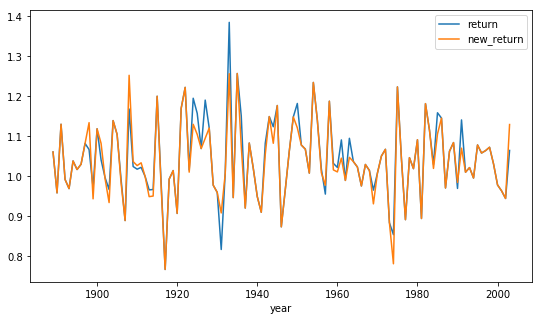

In [35]:
strat.plot(x = 'year', y = ['return', 'new_return'], figsize = (9,5))

Volatility of its returns looks to be about the same.

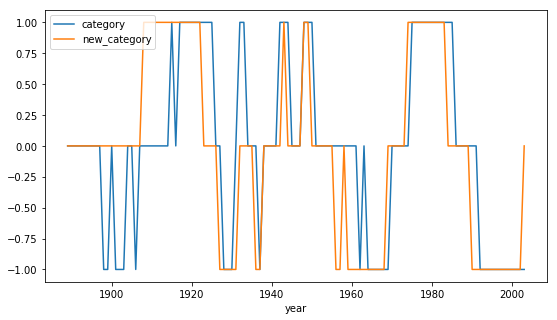

In [36]:
strat.plot(x = 'year', y = ['category', 'new_category'], figsize = (9,5))

Here are the time frames where the underweight/overweight categories strayed from each other.

How to assess the strategy:
- Total Return Compared to Benchmark (using historical CAPE quantile bounds)
- Total Return split by timeframe (we think there was a regime shift post 1999, as seen in our model's decrease in R^2 from 1999 to 2013)
- Stress Test: see performance only when the two strategies diverge to avoid only looking at bigger picture which can be skewed by compounding of previous returns
- Number of trades
- Measure volatility
- Drawdown stats (max drawdown)
- Correlation to benchmark
- Sharpe Ratio, t-stat, number of standard deviations away from 0 profitability
- Test strategy with other indices including other countries'
    - Testing against lower correlated indices is good to see how it performs


Other Ideas:
- Make adjustments to CAPE based on Accounting standard switch
- Instead of fixed weightings, make them more incremental based on how far CAPE is into undervalued/overvalued territory


Would be nice to have color gradient on the Returns chart to show signal for price movement

### Make a model based on CAPE and RLONG
Idea is that interest rates affect the attractiveness of Equities so we want to include them into our model

In [37]:
feature_cols = ['log_CAPE_edit', 'RLONG']
X = dfb[feature_cols]
y = dfb['P_Growth_10_edit']

#X = X.reshape(-1,1)
y = y.reshape(-1,1)

linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
# Run the plot again, same code as before
preds = linreg.predict(X)

In [39]:
# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

print("Mean squared error: %.2f"
      % mean_squared_error(y, preds))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, preds))

[1.49632972]
[[-0.54070233  0.02774901]]
Mean squared error: 0.22
Variance score: 0.21


Shows that adding RLONG improves R^2 but only marginally

### One of the critiques is that accounting practices have changed. Add variable that indicates the different timeframes when accounting changed

In [40]:
dfb['accounting'] = dfb['year'].apply(lambda x: 0 if x <1999 else 1)

In [41]:
feature_cols = ['log_CAPE_edit', 'RLONG', 'accounting']
X = dfb[feature_cols]
y = dfb['P_Growth_10_edit']

#X = X.reshape(-1,1)
y = y.reshape(-1,1)

linreg = LinearRegression()
linreg.fit(X, y)

# Run the plot again, same code as before
preds = linreg.predict(X)

# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

print("Mean squared error: %.2f"
      % mean_squared_error(y, preds))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, preds))

[1.4982439]
[[-0.54141482  0.02771688  0.00313599]]
Mean squared error: 0.22
Variance score: 0.21


Accounting doesn't really change the R^2

### What if you add year to the model to suggest gradual shift of regimes?

In [42]:
feature_cols = ['log_CAPE_edit', 'RLONG', 'accounting','year']
X = dfb[feature_cols]
y = dfb['P_Growth_10_edit']

#X = X.reshape(-1,1)
y = y.reshape(-1,1)

linreg = LinearRegression()
linreg.fit(X, y)

# Run the plot again, same code as before
preds = linreg.predict(X)

# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

print("Mean squared error: %.2f"
      % mean_squared_error(y, preds))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, preds))

[-10.03792838]
[[-0.6314599  -0.02476487 -0.25520549  0.00618571]]
Mean squared error: 0.20
Variance score: 0.29


Not sure if this is good to add...lookback bias?

### Check for overfitting

In [43]:
# View the correlations
dfb[feature_cols].corr()

,log_CAPE_edit,RLONG,accounting,year
log_CAPE_edit,1.000000,-0.200285,0.430552,0.164762
RLONG,-0.200285,1.000000,0.031361,0.595412
accounting,0.430552,0.031361,1.000000,0.353232
year,0.164762,0.595412,0.353232,1.000000


Nothing TOO highly correlated. Going to skip using Ridge or Lasso Regression due to this

### Try Random Forest

In [44]:
feature_cols = ['P', 'D', 'E', 'R', 'RLONG', 'CPI', 'RealR', 'C', 'RealP', 'P*', 'P*r',
       'P*C', 'RealD', 'RealE', 'P/E', 'E10',
       'CAPE P/E10', 'year', 'RealP_edit', 'RealE_edit', 'E10_edit',
       'CAPE_edit', 'P_Growth_10_edit', 'log_CAPE_edit', 'accounting',
       'accounting_after', 'accounting_before']

X = dfb[feature_cols]
y = dfb['Return']

KeyError: "['accounting_after' 'accounting_before'] not in index"

Use Decision Tree first to find feature importances. Optimize max_depth for Tree.

In [ ]:
# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use 5-fold cross-validation with each value of max_depth

for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [ ]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.figure(figsize=(10, 7))
plt.plot(max_depth_range, RMSE_scores, linewidth = 3)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()

In [45]:
treereg = DecisionTreeRegressor(max_depth=2, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [46]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 
              'importance':treereg.feature_importances_}).sort_values('importance', ascending = False)

ValueError: arrays must all be same length

Start with the Random Forest

In [184]:
#Intialize
rfreg = RandomForestRegressor()
#Show model details
rfreg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Optimize n_estimators

In [185]:
# list of values to try for n_estimators
estimator_range = range(10, 210, 10)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators. Will take a while.

for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

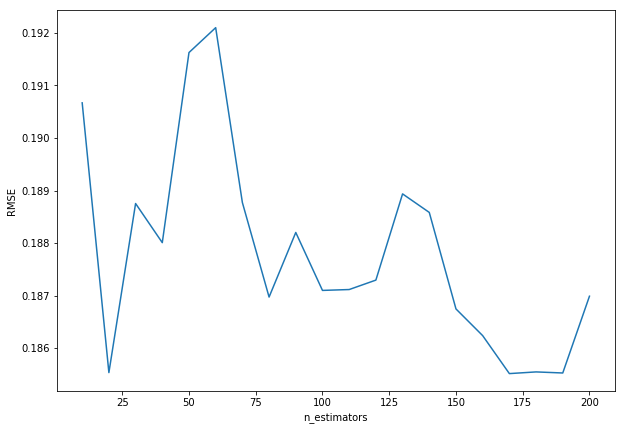

In [186]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.figure(figsize=(10, 7))
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE');

In [187]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 5-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=175, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Optimize max_features

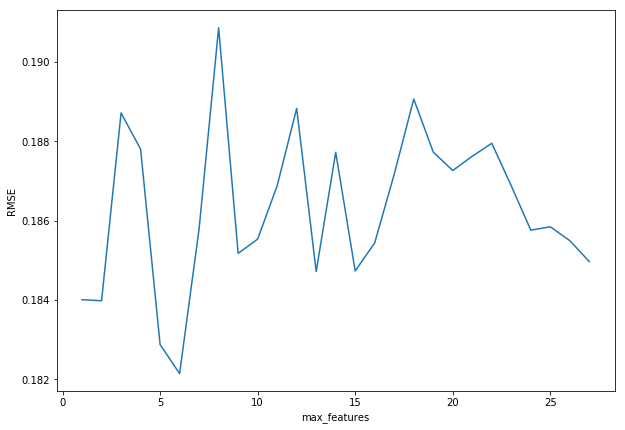

In [188]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.figure(figsize=(10, 7))
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE');

In [190]:
# max_features=6 is best and n_estimators=150 is sufficiently large
rfreg = RandomForestRegressor(n_estimators=175, 
                              max_features=6,
                              oob_score=True,
                              random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=175, n_jobs=1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [191]:
# compute feature importances
pd.DataFrame({'feature':feature_cols,
              'importance':rfreg.feature_importances_}).sort_values('importance', ascending = False)

,feature,importance
22,P_Growth_10_edit,0.106224
6,RealR,0.102828
3,R,0.050900
4,RLONG,0.049216
16,CAPE P/E10,0.046367
11,P*C,0.045500
19,RealE_edit,0.044698
21,CAPE_edit,0.043325
8,RealP,0.041586
13,RealE,0.040068


What's the out of bag score?

In [192]:
# compute the out-of-bag R-squared score
rfreg.oob_score_

0.047174268744482606

Score is pretty good! 78% of variance in dataset is explained by this RF model